# Reducing Bias in Machine Learning Models:
### Modeling Part 2: Advanced Models (Base and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 4: Advanced Models (Base and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Random Forest](#ran)
    - 1.3: [xGBoost](#boost)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our advanced models and then optimizing them for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 4: Advanced Modelling (Base and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [111]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score
)
import xgboost as gb
from joblib import dump
import json
import shap

Loading the clean csv file

In [64]:
health_data = pd.read_csv('Data/clean_health_data_pt3.csv')

In [65]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [66]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lungexternl,pmh_lymphenlarg,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_conjunctivitis,cc_constipation,cc_cough,cc_cyst,cc_decreasedbloodsugar-symptomatic,cc_dehydration,cc_dentalpain,cc_depression,cc_detoxevaluation,cc_diarrhea,cc_dizziness,cc_drug/alcoholassessment,cc_drugproblem,cc_dyspnea,cc_

In [67]:
health_data.shape

(105627, 419)

In [68]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int64(419)
memory usage: 337.7 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [69]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [70]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(419)
memory usage: 42.2 MB


As we can see, the memory usage has decreased from 337.7 mb to 42.2mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Random Forest

To build on top of the prior base model of a decision tree, I will be doing random forest. Random Forest is an ensemble learning method that combines the predictions of multiple individual models (decision trees) to create a more robust and accurate model. Random Forests can effectively handle datasets with binary features. The random subset of features considered at each split helps in decorrelating trees and capturing diverse patterns.

In [71]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Cross-Validation Scores (5-fold): [0.77139762 0.76814735 0.7677862  0.75907531 0.76792487]
Mean CV Accuracy (5-fold): 0.7668662694178622
Test Accuracy: 0.779608065890372

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80     11348
           1       0.79      0.71      0.75      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.78      0.78     21126
weighted avg       0.78      0.78      0.78     21126


Confusion Matrix (Test):
 [[9488 1860]
 [2796 6982]]


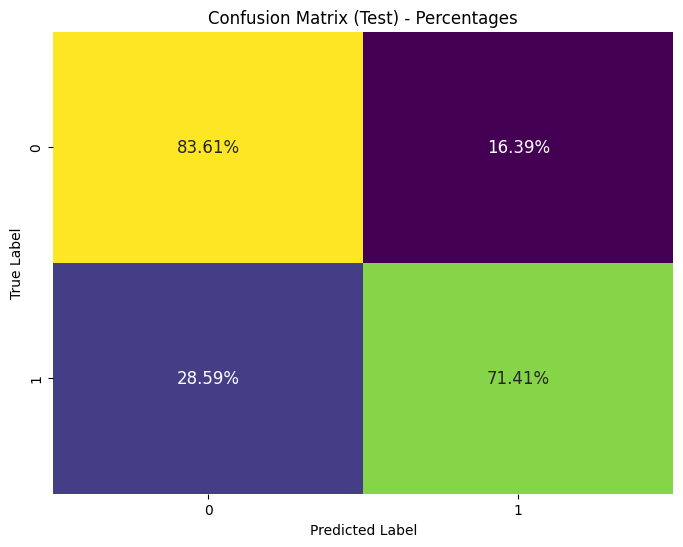

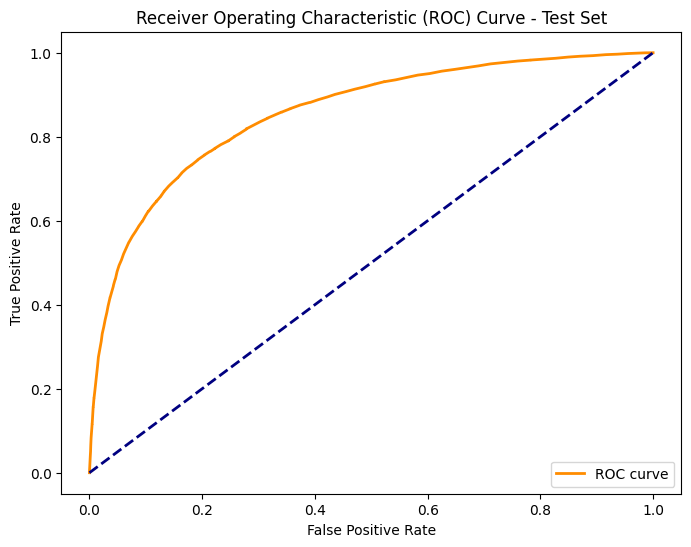

AUC-ROC Score: 0.8552006419495529
Runtime: 30.21 seconds


In [108]:
# Record start time
start_time = time.time()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Record time
end_time = time.time()

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Key takeaways:
- The decision tree model shows reasonable performance on the test set, with an accuracy of 78.49%.
- Precision, recall, and F1-score are reasonably balanced for both classes, indicating a fair trade-off between precision and recall.
- The model tends to perform slightly better on the negative class (0), as indicated by higher precision, recall, and F1-score for this class.
- The confusion matrix provides a detailed breakdown of correct and incorrect predictions.
- The decision tree is better at identifying true negatives (admission) than true positives (discharge), as reflected in the higher recall for the negative class.
- The CV shows similar performance between all 5 folds. 
____

Now for us to find the best hyper parameters. 

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 72}
Test Accuracy: 0.7877496923222569

Cross-Validation Scores (5-fold): [0.78107804 0.77840237 0.78088757 0.78390533 0.78325444]
Mean CV Accuracy (5-fold): 0.7815055493722756

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81     11348
           1       0.81      0.71      0.76      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.78      0.78     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9706 1642]
 [2842 6936]]


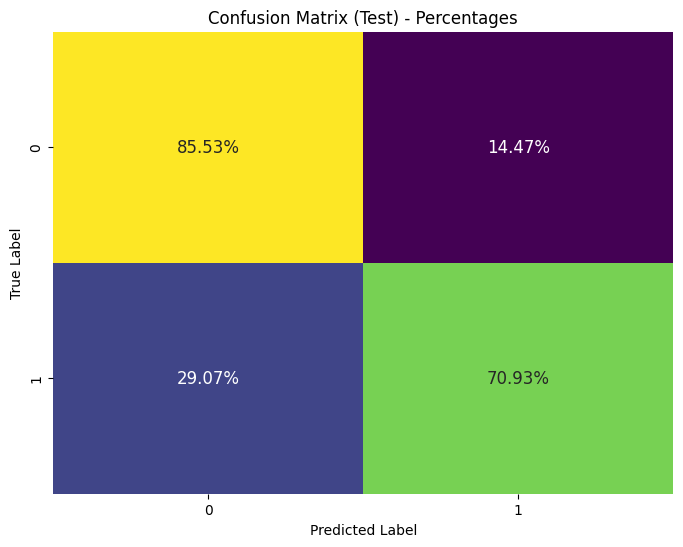

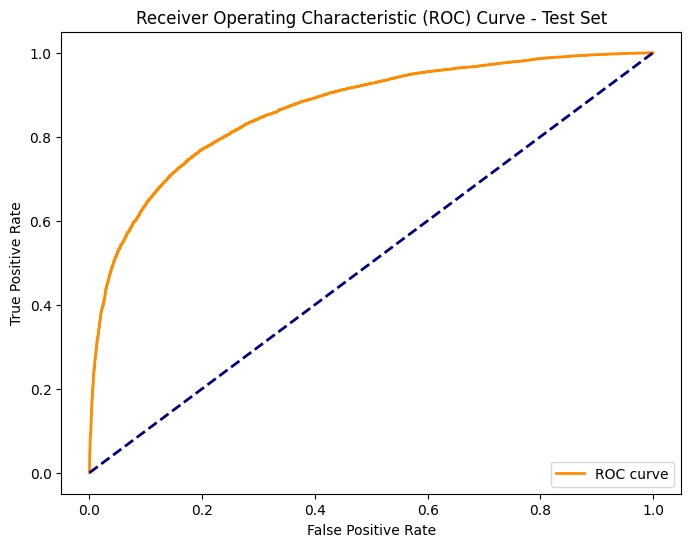

AUC-ROC Score: 0.865152494831866
Runtime: 86.67 seconds


In [73]:
# Record start time
start_time = time.time()

# Define a smaller parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Key takeaways: 
- Test Accuracy: optimized decision tree model (0.7877) has a higher test accuracy compared to the baseline model (0.7598), indicating an improvement.
- Precision, Recall, and F1-Score: 
    - The optimized model generally shows improvements in precision, recall, and F1-score for both classes compared to the baseline model.
- CV showed relatively similar performance in all 5 folds. 

In summary, the optimized decision tree model performs better than the baseline decision tree model in terms of accuracy and most of the classification metrics. The hyperparameter tuning process has led to improved model performance. I will run another iteration based on the previously found best parameters and see if I can possibly get any improvements. 

/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/b

Best Parameters: {'n_estimators': 60, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini'}
Test Accuracy: 0.7810754520496072

Cross-Validation Scores (5-fold): [0.7744135  0.77221773 0.77730267 0.776147   0.7710356 ]
Mean CV Accuracy (5-fold): 0.77422329910086

Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81     11348
           1       0.80      0.70      0.75      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.78      0.78     21126
weighted avg       0.78      0.78      0.78     21126


Confusion Matrix (Test):
 [[9680 1668]
 [2957 6821]]


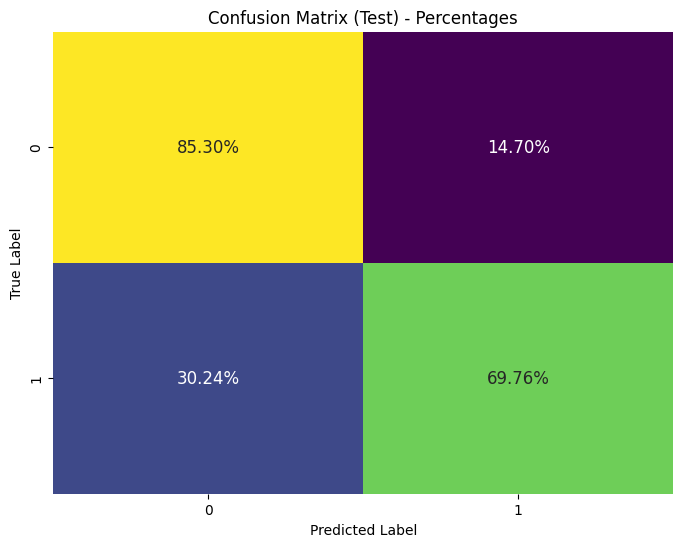

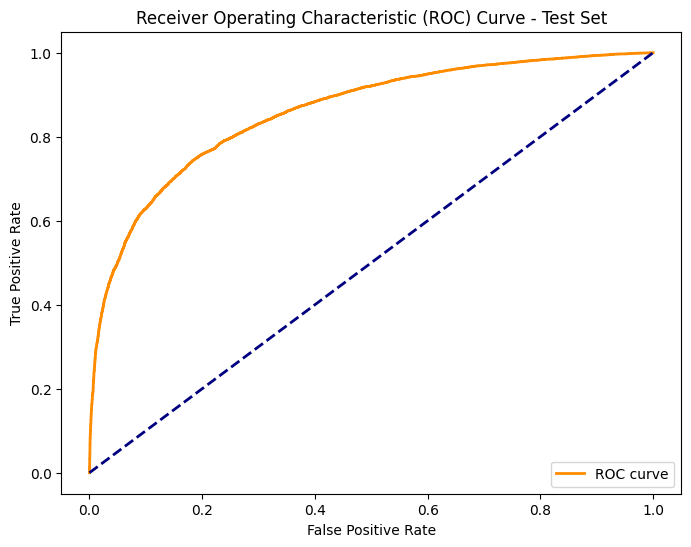

AUC-ROC Score: 0.858569229672793
Runtime: 24.66 seconds


In [88]:
# Record start time
start_time = time.time()

# Define a smaller parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [60, 70, 80],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation and fewer iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Get the best model from the random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print('AUC-ROC Score:', roc_auc)

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Top 20 Features:
                                      Feature  Importance
413       dum_huse__1-to-2_antihyperglycemics    0.236822
414       dum_huse__3-to-6_antihyperglycemics    0.063315
416                 dum_huse__1-to-2_hormones    0.047705
380                demo_employstatus_Employed    0.033378
338                      cc_shortnessofbreath    0.028869
31                       pmh_chrkidneydisease    0.023154
39                            pmh_coronathero    0.020580
395    dum_triage_vital__pre-hypertension_dbp    0.017680
378                            demo_age_80-89    0.016874
211                    cc_alteredmentalstatus    0.016806
30                               pmh_chfnonhp    0.015807
1                                   demo_race    0.015748
227                              cc_chestpain    0.015567
81                                    pmh_htn    0.015069
387  dum_triage_vital__hypertension(high)_sbp    0.013283
390    dum_triage_vital__pre-hypertension_sbp    0.0098

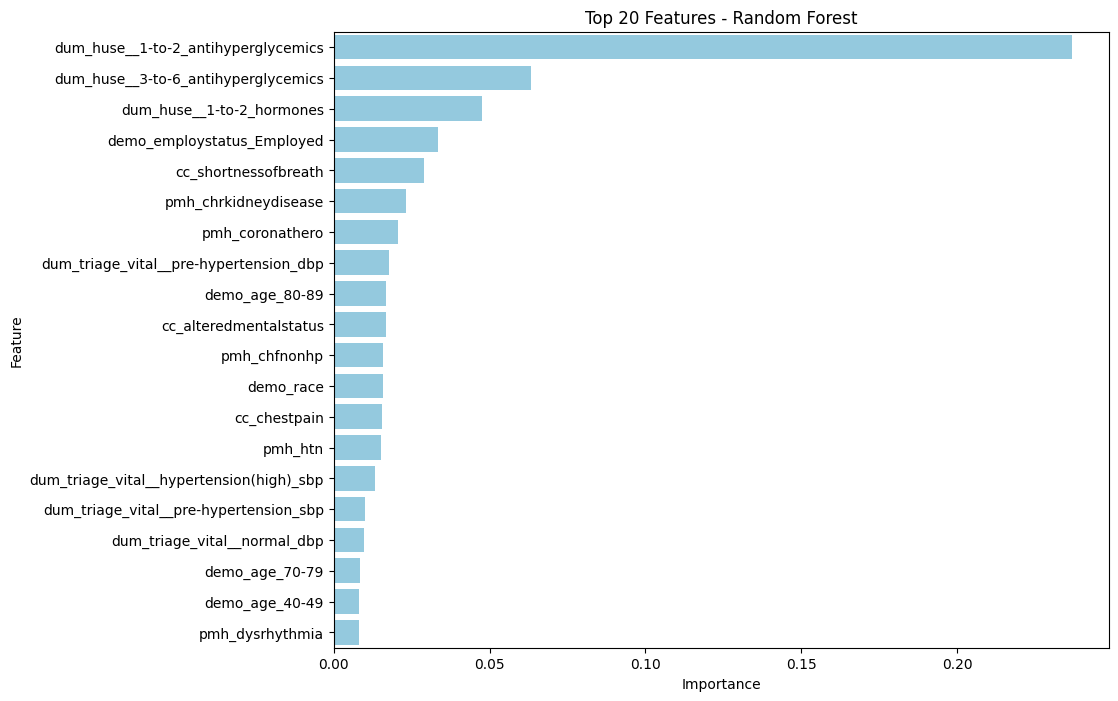

In [97]:
# Extract feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 features
top_20_features = feature_importance_df.head(20)
print("Top 20 Features:")
print(top_20_features)

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, color='skyblue')
plt.title('Top 20 Features - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

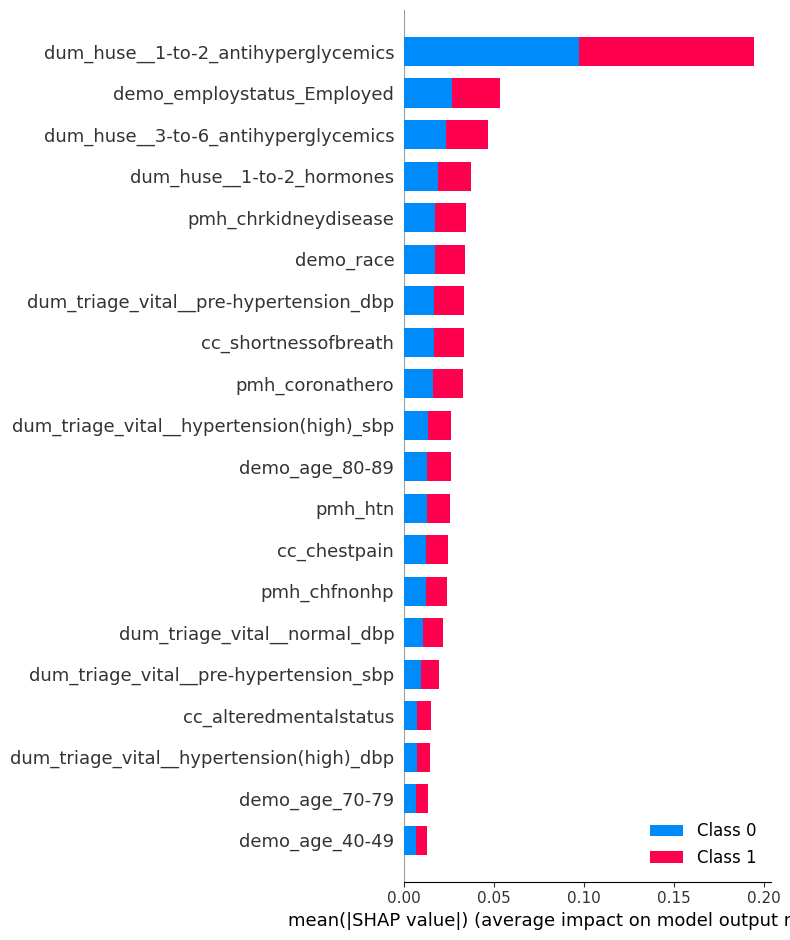

In [116]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

---
 1.3 XGBoost

XGBoost is another form of ensemble learning that's effective for structure data. It's a form of gradient boosting which builds a model in a stage-wise fashion where each iteration corrects the errors of the previous one. It's well suited for binary tasks and important for explainability. It will be a great addition to the other models. 


Cross-Validation Scores (5-fold): [0.77870865 0.78329962 0.78171049 0.79066744 0.78459983]
Mean CV Accuracy (5-fold): 0.7837972057598289
Classification Report (Training):
               precision    recall  f1-score   support

           0       0.80      0.88      0.84     18637
           1       0.84      0.74      0.79     15974

    accuracy                           0.82     34611
   macro avg       0.82      0.81      0.81     34611
weighted avg       0.82      0.82      0.82     34611

Training Accuracy: 0.8180058362948196


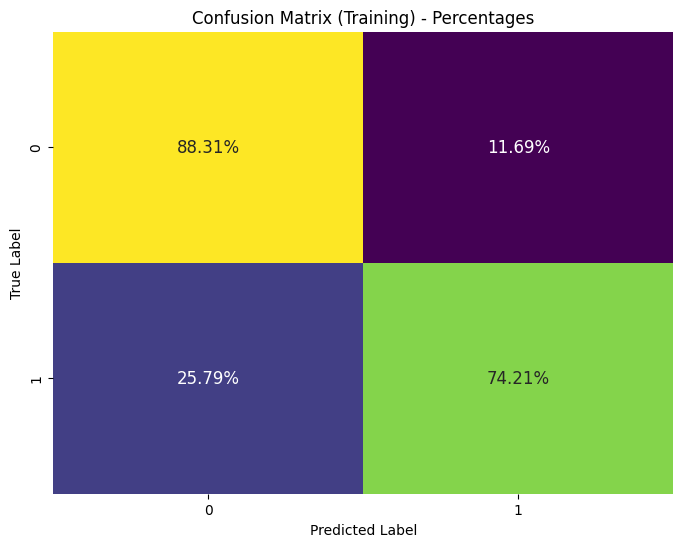


Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      4696
           1       0.80      0.72      0.76      3957

    accuracy                           0.79      8653
   macro avg       0.79      0.78      0.78      8653
weighted avg       0.79      0.79      0.79      8653

Validation Accuracy: 0.787819253438114


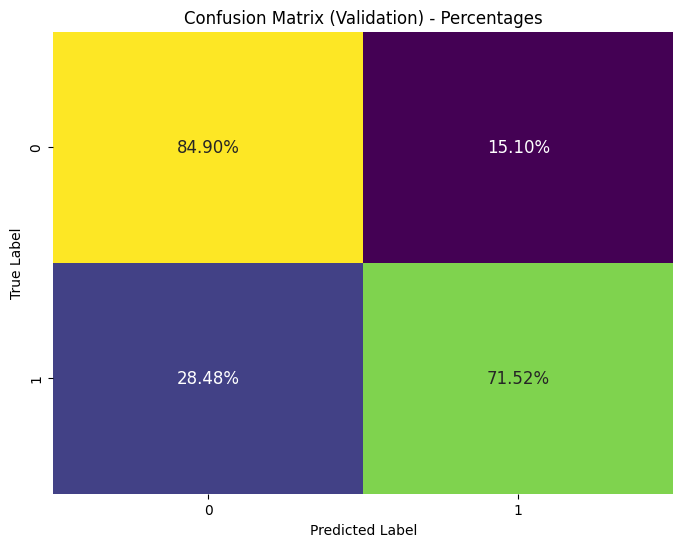

AUC-ROC Score: 0.8641431375360078


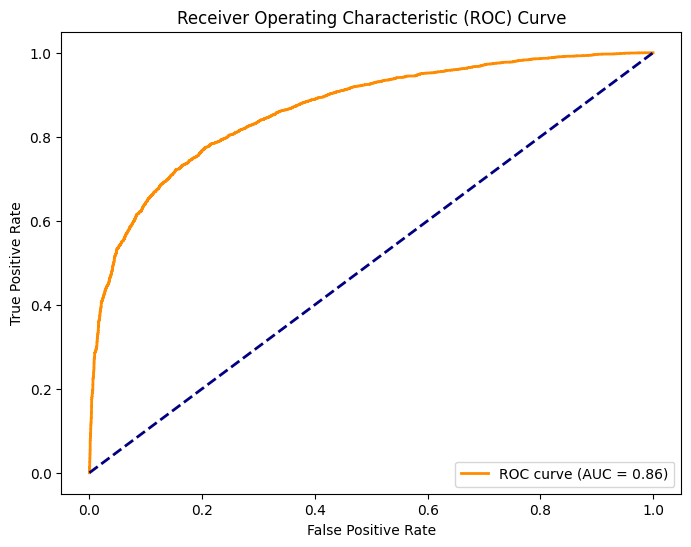

Runtime: {:.2f} seconds.format(runtime)


In [106]:
# Record time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Predictions on the validation set
y_pred_valid = xgb_model.predict(X_valid)

# Predictions on the training set
y_pred_train = xgb_model.predict(X_train)

# 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)


# Classification Report for the training set
print('Classification Report (Training):\n', classification_report(y_train, y_pred_train))

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Confusion Matrix for the training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Calculate percentages for the confusion matrix
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Training) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Evaluate performance metrics for the validation set
print('\nClassification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds.format(runtime)')


Key Takeaways: 

Cross-Validation:
- The 5-fold cross-validation scores are consistent, with an average accuracy of approximately 78.93%. This suggests reasonable generalization performance.

Training Set:
- The model achieves an accuracy of 81.21% on the training set.
- Precision and recall are reasonably balanced for both classes (0 and 1).
- The F1-score for class 1 (positive class) is slightly lower, indicating some difficulty in capturing all positive instances.

 Validation Set:
-  The model performs slightly worse on the validation set with an accuracy of 78.79%.
- Precision and recall show a similar pattern to the training set, and the F1-score for class 1 is also lower.

AUC-ROC Score:
- The AUC-ROC score is 0.87, indicating good discriminatory power to distinguish between the positive and negative classes.

_____

Now that we have a good baseline model for xGBoost, let's now try to optimize it with the best hyper parameters. 

Best Parameters: {'colsample_bytree': 0.9871269988441895, 'learning_rate': 0.16706813022278874, 'max_depth': 6, 'n_estimators': 148, 'subsample': 0.8744565533123486}
Training Accuracy: 0.8245810459404797
Classification Report (Training):
               precision    recall  f1-score   support

           0       0.81      0.89      0.84     14903
           1       0.85      0.75      0.80     12785

    accuracy                           0.82     27688
   macro avg       0.83      0.82      0.82     27688
weighted avg       0.83      0.82      0.82     27688



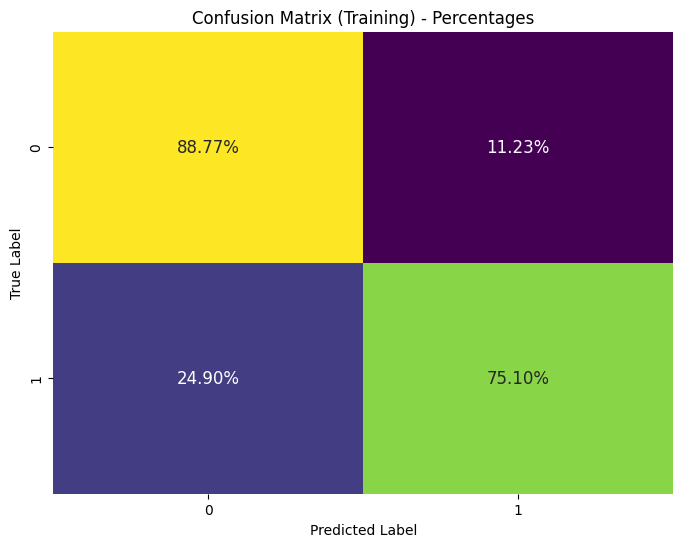

Validation Accuracy: 0.786075400837787
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      3734
           1       0.81      0.70      0.75      3189

    accuracy                           0.79      6923
   macro avg       0.79      0.78      0.78      6923
weighted avg       0.79      0.79      0.78      6923



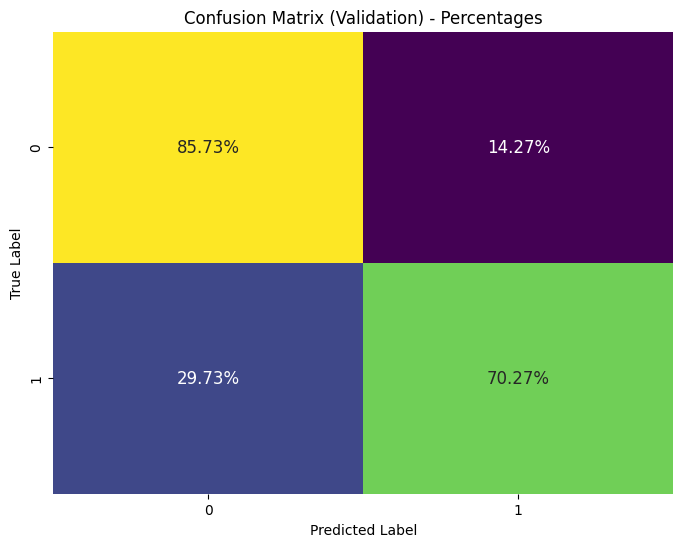

AUC-ROC Score: 0.8650991801457305


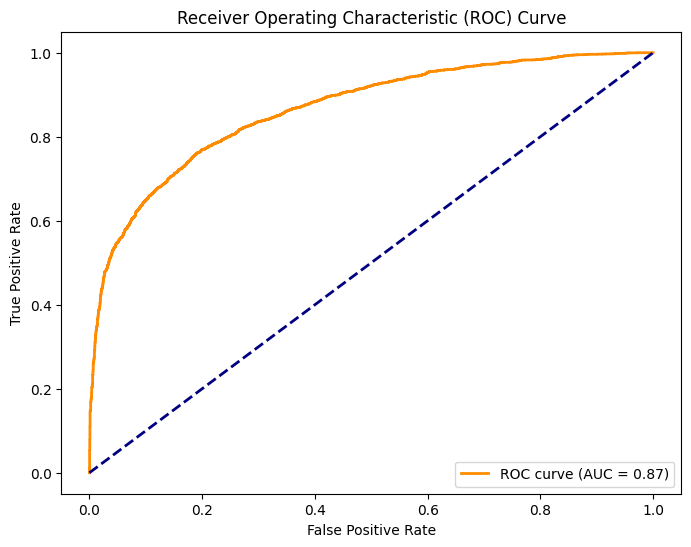


Cross-Validation Scores (5-fold): [0.79017696 0.77988443 0.78367642 0.77713563 0.78544338]
Mean CV Accuracy (5-fold): 0.7832633650781475
Runtime: 76.61 seconds


In [107]:
# Record end time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 151),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
}

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Classification Report for the training set
print('Classification Report (Training):\n', classification_report(y_train, y_pred_train))

# Confusion Matrix for the training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Calculate percentages for the confusion matrix
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Training) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


Key takeaways:

Training Set:
- The optimized model achieves an improved accuracy of 81.83% on the training set.
- Precision and recall for both classes are well-balanced, and the F1-score for class 1 has improved compared to the base model.

Validation Set:
- The optimized model performs better on the validation set with an accuracy of 79.63%.
- Precision, recall, and F1-score for both classes have improved compared to the base model.

Cross-Validation:
- The 5-fold cross-validation scores for the optimized model are consistent, with an average accuracy of approximately 78.96%.

The optimized model shows slight improvements over the base model, especially in terms of F1-scores on the training and validation sets. The optimized model demonstrates better generalization to the validation set.

Now that we have the best parameters, let's run another iteration of random search with these values in mind and see if we can improve performance. 

Best Parameters: {'subsample': 0.92, 'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.86}
Training Accuracy: 0.819688424556213
Classification Report (Training):
               precision    recall  f1-score   support

           0       0.80      0.88      0.84     23333
           1       0.84      0.75      0.79     19931

    accuracy                           0.82     43264
   macro avg       0.82      0.81      0.82     43264
weighted avg       0.82      0.82      0.82     43264



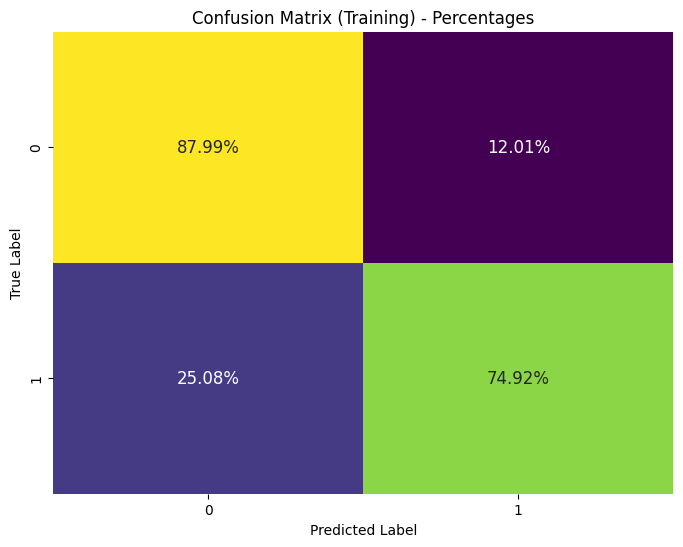

Validation Accuracy: 0.7984467455621301
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      5926
           1       0.81      0.73      0.77      4890

    accuracy                           0.80     10816
   macro avg       0.80      0.79      0.79     10816
weighted avg       0.80      0.80      0.80     10816



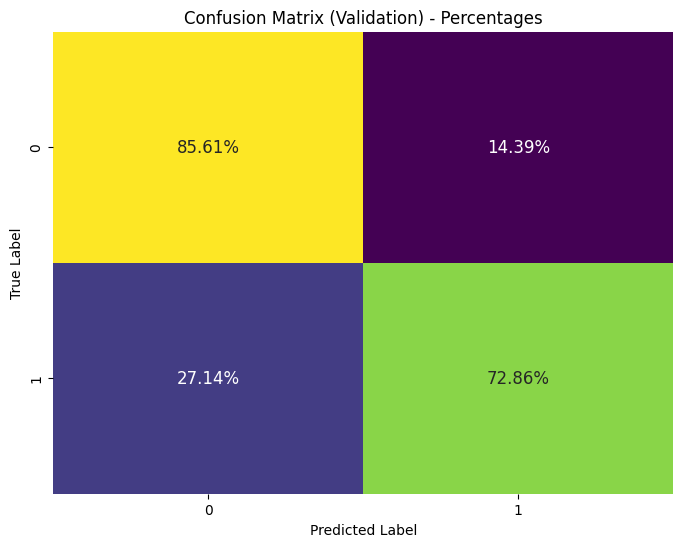

AUC-ROC Score: 0.8761137188239134


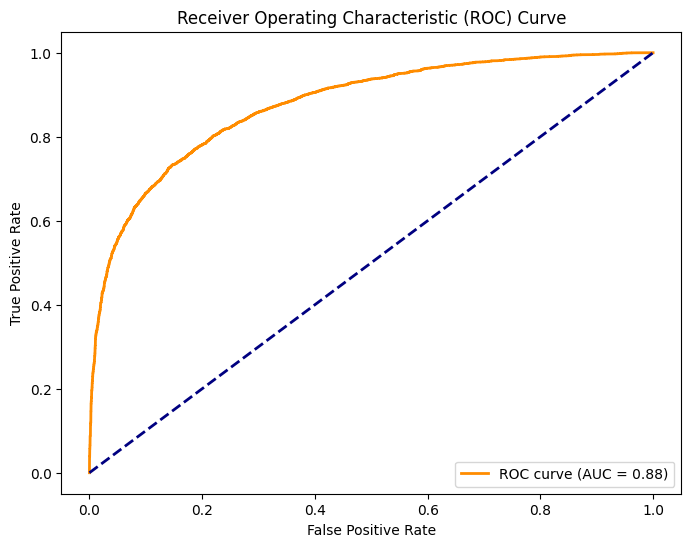


Cross-Validation Scores (5-fold): [0.79174853 0.78839709 0.79047729 0.79093956 0.78478964]
Mean CV Accuracy (5-fold): 0.7892704215796605
Runtime: 122.40 seconds


In [85]:
# Record end time
start_time = time.time()

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [5, 6, 7, 8, 9],
    'n_estimators': [130, 140, 150, 160, 170],
    'subsample': [0.9, 0.92, 0.94, 0.96, 0.98, 1.0],
    'colsample_bytree': [0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
}

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Record time
end_time = time.time()

# Print the best parameters
print('Best Parameters:', random_search.best_params_)

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_xgb_model.predict(X_valid)

# Make predictions on the training set
y_pred_train = best_xgb_model.predict(X_train)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Accuracy for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Classification Report for the training set
print('Classification Report (Training):\n', classification_report(y_train, y_pred_train))

# Confusion Matrix for the training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Calculate percentages for the confusion matrix
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Training) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print('Validation Accuracy:', accuracy_valid)

# Evaluate performance metrics for the validation set
print('Classification Report (Validation):\n', classification_report(y_valid, y_pred_valid))

# Confusion Matrix for the validation set
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)

# Calculate percentages for the confusion matrix
conf_matrix_percent_valid = conf_matrix_valid / conf_matrix_valid.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_valid, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Validation) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
print('AUC-ROC Score:', roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, best_xgb_model.predict_proba(X_valid)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display cross-validation results
print('\nCross-Validation Scores (5-fold):', cv_scores)
print('Mean CV Accuracy (5-fold):', mean_cv_accuracy)

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Top 20 Features and Importances:
dum_huse__3-to-6_antihyperglycemics: 0.08082906901836395
dum_huse__1-to-2_antihyperglycemics: 0.07792408764362335
dum_huse__1-to-2_hormones: 0.020719990134239197
cc_alteredmentalstatus: 0.014906605705618858
demo_employstatus_Employed: 0.010644073598086834
cc_shortnessofbreath: 0.010568350553512573
demo_age_80-89: 0.01030835323035717
demo_age_90-99: 0.010192587040364742
cc_strokealert: 0.010033372789621353
cc_abnormallab: 0.009902638383209705
cc_chestpain: 0.009238120168447495
cc_motorvehiclecrash: 0.009238063357770443
cc_dyspnea: 0.008082152344286442
cc_fever-9weeksto74years: 0.00805816613137722
cc_weakness: 0.007758484221994877
cc_syncope: 0.007168824318796396
dum_triage_vital__fever(high_temp): 0.007164699025452137
pmh_chrkidneydisease: 0.006477514747530222
cc_neurologicproblem: 0.006358380429446697
cc_gibleeding: 0.006330953910946846


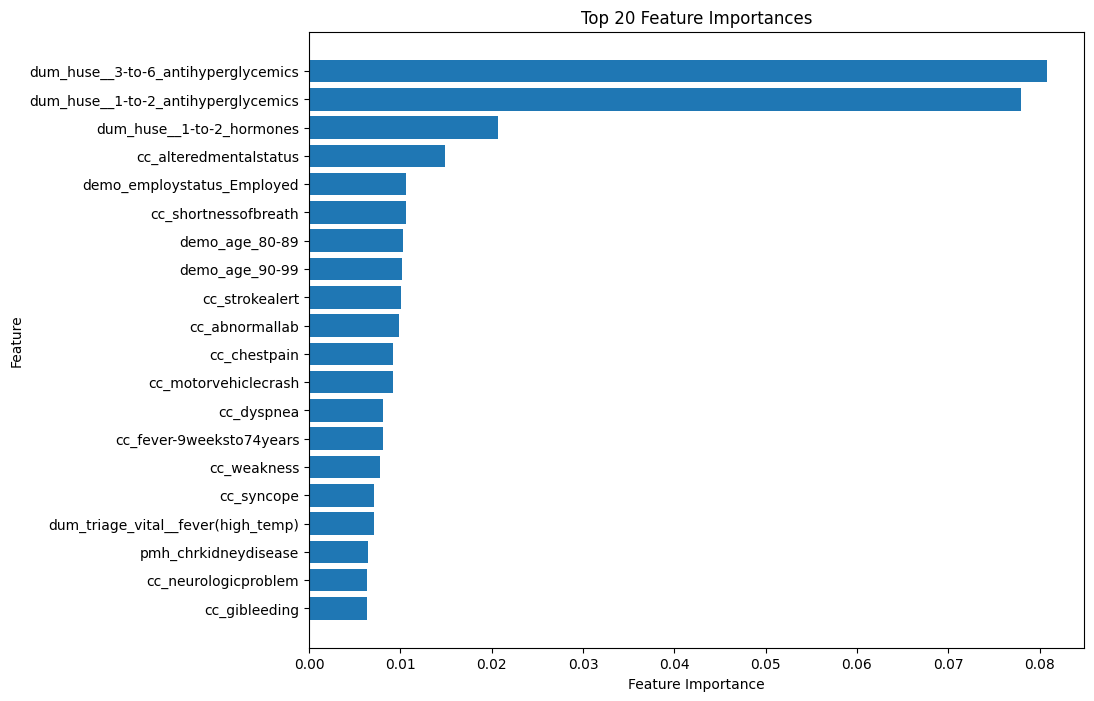

In [115]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get the indices of the top 20 features
top20_indices = np.argsort(feature_importances)[-20:]

# Get the names of the top 20 features
top20_features = X_train.columns[top20_indices]

# Print top 20 features and their importances
print("Top 20 Features and Importances:")
for feature, importance in zip(top20_features[::-1], feature_importances[top20_indices][::-1]):
    print(f'{feature}: {importance}')

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(top20_features)), feature_importances[top20_indices], align='center')
plt.yticks(range(len(top20_features)), top20_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

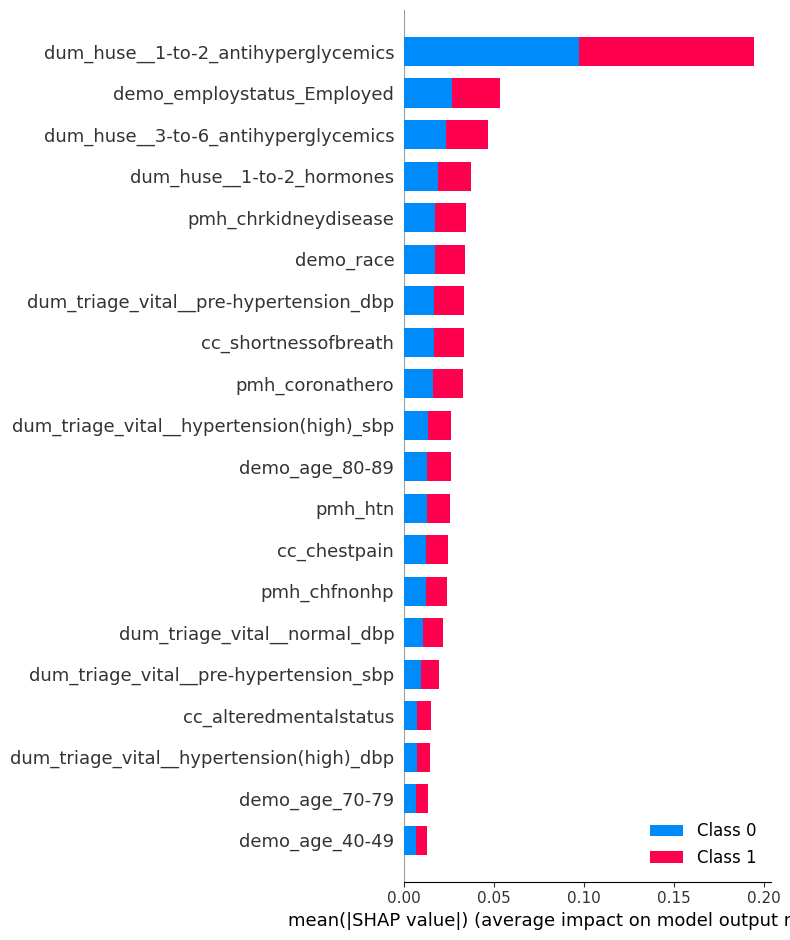

In [114]:
# Create an explainer
explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

---
### <a id = 'conc'></a> Conclusion

Now that we have ran our advanced models and optimized them. It's clear that of the advanced models, xGBoost performed the best. It's performance is slightly better than the optimized logistic regression. I will now export these models so that it can later be used on unseen data.

In [80]:
# Save the model
dump(best_rf_model, 'KLO_BStn_RF.joblib')

['KLO_BStn_RF.joblib']

Now for the xGBoost

In [84]:
# Save the XGBoost model to a JSON file
model_json = best_xgb_model.get_booster().get_dump(dump_format='json')
with open('KLO_BStn_xGB.json', 'w') as json_file:
    json.dump(model_json, json_file)


Now that all of the modelling has been completed, we can now look into how we could build a discrimination test and see if implementing this test will affect the performance of these models. 

____